### import ライブラリ

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
import scipy.stats
from sklearn.feature_selection import SelectPercentile, SelectFromModel

/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 信用情報
Kaggleの Home Credit Default Risk コンペティションの学習および推定を行います。

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

* 何を学習し、何を予測するのか
* どのようなファイルを作りKaggleに提出するか
* 提出されたものはどういった指標値で評価されるのか
<br /><br />

![](https://t.gyazo.com/teams/diveintocode/f670fe8c4463d588543dd754022b641c.png)

### 【問題1】解答

* 何を学習し、何を予測するのか
→取引情報などから学習し、支払いが困難なクライアントを予測する。
* どのようなファイルを作りKaggleに提出するか
→ファイルにはヘッダーを含め、SK_ID_CURR及び支払いが困難なクライアントである確率をCSVファイルで提出する。
* 提出されたものはどういった指標値で評価されるのか
→予測された確率と実際の値との間のROC曲線の下の面積

# ベースラインモデルの作成

まずは単純な方法による **ベースラインモデル**　を作成します。精度の基準となるモデルです。


精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。


検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [2]:
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

In [3]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

### 【問題2】解答

#### 分析

In [4]:
df.shape

(307511, 122)

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [7]:
# 欠損値チェック
null_list = pd.concat([df.isnull().sum(),df.isnull().sum()*100/len(df)], axis=1)
null_list.columns = ['Num_null', 'Ratio']
null_list

,Num_null,Ratio
SK_ID_CURR,0,0.000000
TARGET,0,0.000000
NAME_CONTRACT_TYPE,0,0.000000
CODE_GENDER,0,0.000000
FLAG_OWN_CAR,0,0.000000
FLAG_OWN_REALTY,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
AMT_ANNUITY,12,0.003902


#### 前処理

In [8]:
# 文字列のカテゴリカル変数を除外
non_objct_cols = df.select_dtypes(exclude=object)
df = df[non_objct_cols.columns]

In [9]:
df.shape

(307511, 106)

In [10]:
# 欠損値を０に置き換え
df = df.fillna(0)

In [11]:
df.shape

(307511, 106)

In [12]:
# データとターゲットに分割
target = df.pop('TARGET')

# ndarrayに変換
df, target = df.values, target.values


# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.25, random_state=42)
X_train.shape

(230633, 105)

#### 学習

In [13]:
# ランダムフォレスト
model_1 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)
model_1.fit(X_train, np.ravel(y_train))

y_pred_1 = model_1.predict(X_test)

score_1 = model_1.score(X_test, y_test)
score_1

0.9194698093082546

#### 検証

In [14]:
# 混同行列
confusion_matrix(y_test, y_pred_1)

array([[70687,     0],
       [ 6191,     0]])

In [15]:
y_pred_proba_1 = model_1.predict_proba(X_test)

ROC-AUC SCORE 0.7126592931654263


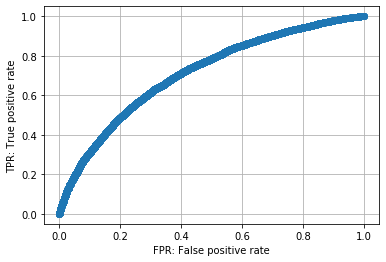

In [16]:
# ROC-AUCスコア
roc_auc_score_1 = roc_auc_score(y_test, y_pred_proba_1[:,1])
print('ROC-AUC SCORE', roc_auc_score_1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_1[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

## 【問題3】テストデータに対する推定
テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。


正しく提出が行えていれば、精度は低くても構いません。

### 【問題3】解答

Private Score:0.50348

Public Score:0.50239


# 特徴量エンジニアリング

ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で **特徴量エンジニアリング（Feature Engineering）** を行ってください。


* どの特徴量を使うか
* どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。


精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

### 【問題4】解答

Private Score:0.68948

Public Score:0.69982

### パターン1
**特徴量**
* 105→2個（短変量統計）

**前処理方法**
* ターゲットエンコーディング
* 欠損値処理を0に置き換えから中央値に置き換え処理した。

**評価指標**
* 0.7126→0.6952

In [17]:
# データ再取得
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

In [18]:
# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)
# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


In [19]:
# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
df[objct_cols_list]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0.083459,0.101419,0.085002,0.079616,0.081830,0.095885,0.089399,0.098077,0.077957,0.105788,0.081604,0.092996,0.069782,0.069434,0.074057,0.069649
1,0.083459,0.069993,0.085002,0.083249,0.074946,0.057550,0.053551,0.075599,0.077957,0.063040,0.077572,0.059148,0.069782,0.069434,0.070247,0.069649
2,0.054783,0.101419,0.072437,0.079616,0.081830,0.095885,0.089399,0.098077,0.077957,0.105788,0.077572,0.069781,0.086188,0.091512,0.091281,0.092607
3,0.083459,0.069993,0.085002,0.079616,0.081830,0.095885,0.089399,0.099446,0.077957,0.105788,0.081604,0.092996,0.086188,0.091512,0.091281,0.092607
4,0.083459,0.101419,0.085002,0.079616,0.081830,0.095885,0.089399,0.098077,0.077957,0.063040,0.081003,0.058824,0.086188,0.091512,0.091281,0.092607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.083459,0.101419,0.085002,0.083249,0.081830,0.095885,0.089399,0.081942,0.116981,0.096318,0.081003,0.066032,0.069782,0.069434,0.074057,0.069649
307507,0.083459,0.069993,0.085002,0.079616,0.081830,0.053864,0.089399,0.058242,0.077957,0.065131,0.077572,0.053996,0.069782,0.069434,0.074057,0.069649
307508,0.083459,0.069993,0.085002,0.079616,0.081830,0.095885,0.053551,0.081942,0.077957,0.062140,0.081003,0.059148,0.069782,0.069434,0.063477,0.069649
307509,0.083459,0.069993,0.085002,0.079616,0.081830,0.074843,0.089399,0.075599,0.077957,0.105788,0.081604,0.081384,0.086188,0.069434,0.074057,0.069649


In [20]:
# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

print(df.isnull().sum())
print(df.shape)

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBER

In [21]:
# データとターゲットに分割
target = df.pop('TARGET')

In [22]:
# 列削除
# df = df.drop(['FLAG_MOBIL', 'FLAG_DOCUMENT_2'], axis=1)

In [23]:
# 短変量統計
select = SelectPercentile(percentile=1) # select 1% features
select.fit(df, target)
mask = select.get_support()
print(df.columns[np.where(mask==True)])
df_selected = select.transform(df) # type:dataFrame->ndarray

# ndarrayに変換
target = target.values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_selected, target, test_size=0.25, random_state=42)
X_train.shape

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype='object')


/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21 95] are constant.
  UserWarning)
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(8513, 2)

Accuracy
 0.9323467230443975

ROC AUC SCORE
 0.6952485276518015

Confusion Matrix
 [[2644    2]
 [ 190    2]]


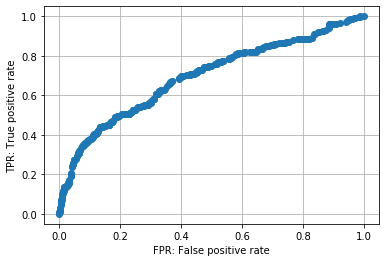

In [24]:
model_2 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)


model_2.fit(X_train, np.ravel(y_train))
y_pred_2 = model_2.predict(X_test)
y_pred_proba_2 = model_2.predict_proba(X_test)

print('Accuracy\n', model_2.score(X_test, y_test))
print('\nROC AUC SCORE\n', roc_auc_score(y_test, y_pred_proba_2[:,1]))
print('\nConfusion Matrix\n',confusion_matrix(y_test, y_pred_2))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_2[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

### パターン2
**特徴量**
* 105→3個（短変量統計）

**前処理方法**
* ターゲットエンコーディング
* 欠損値処理を0に置き換えから中央値に置き換え処理した。

**評価指標**
* 0.7126→0.7213


Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype='object')
Accuracy
 0.9330514446793516

ROC AUC SCORE
 0.7213226725875534

Confusion Matrix
 [[2646    0]
 [ 190    2]]


/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21 95] are constant.
  UserWarning)
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


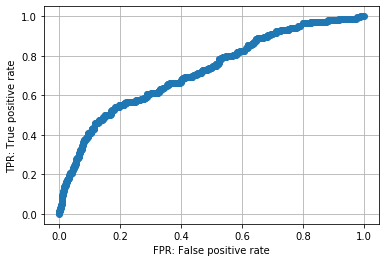

In [25]:
# データ再取得
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')

# 短変量統計
select = SelectPercentile(percentile=2) # select 1% features
select.fit(df, target)
mask = select.get_support()
df_selected = select.transform(df) # type:dataFrame->ndarray

print(df.columns[np.where(mask==True)])

# ndarrayに変換
target = target.values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_selected, target, test_size=0.25, random_state=42)
# X_train.shape


# モデル構築
model_2 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)


model_2.fit(X_train, np.ravel(y_train))
y_pred_2 = model_2.predict(X_test)
y_pred_proba_2 = model_2.predict_proba(X_test)

print('Accuracy\n', model_2.score(X_test, y_test))
print('\nROC AUC SCORE\n', roc_auc_score(y_test, y_pred_proba_2[:,1]))
print('\nConfusion Matrix\n',confusion_matrix(y_test, y_pred_2))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_2[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

### パターン3
**特徴量**
* 105→4個（短変量統計）

**前処理方法**
* ターゲットエンコーディング
* 欠損値処理を0に置き換えから中央値に置き換え処理した。

**評価指標**
* 0.7126→0.7371

Index(['REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')
Accuracy
 0.9316420014094433

ROC AUC SCORE
 0.7371907675107079

Confusion Matrix
 [[2643    3]
 [ 191    1]]


/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21 95] are constant.
  UserWarning)
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


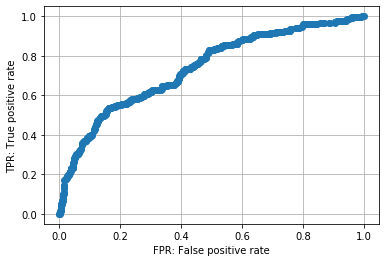

In [26]:
# データ再取得
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')

# 短変量統計
select = SelectPercentile(percentile=3) # select 1% features
select.fit(df, target)
mask = select.get_support()
df_selected = select.transform(df) # type:dataFrame->ndarray

print(df.columns[np.where(mask==True)])

# ndarrayに変換
target = target.values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_selected, target, test_size=0.25, random_state=42)
# X_train.shape


# モデル構築
model_2 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)


model_2.fit(X_train, np.ravel(y_train))
y_pred_2 = model_2.predict(X_test)
y_pred_proba_2 = model_2.predict_proba(X_test)

print('Accuracy\n', model_2.score(X_test, y_test))
print('\nROC AUC SCORE\n', roc_auc_score(y_test, y_pred_proba_2[:,1]))
print('\nConfusion Matrix\n',confusion_matrix(y_test, y_pred_2))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_2[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

### パターン4
**特徴量**
* 105→5個 (短変量統計)

**前処理方法**
* ターゲットエンコーディング
* 欠損値処理を0に置き換えから中央値に置き換え処理した。

**評価指標**
* 0.7126→0.7173

Index(['OCCUPATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3'],
      dtype='object')
Accuracy
 0.9334038054968288

ROC AUC SCORE
 0.7173465450995213

Confusion Matrix
 [[2645    1]
 [ 188    4]]


/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21 95] are constant.
  UserWarning)
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


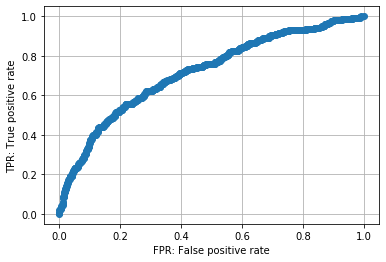

In [27]:
# データ再取得
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')

# 短変量統計
select = SelectPercentile(percentile=4) # select 1% features
select.fit(df, target)
mask = select.get_support()
df_selected = select.transform(df) # type:dataFrame->ndarray

print(df.columns[np.where(mask==True)])

# ndarrayに変換
target = target.values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_selected, target, test_size=0.25, random_state=42)
# X_train.shape


# モデル構築
model_2 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)


model_2.fit(X_train, np.ravel(y_train))
y_pred_2 = model_2.predict(X_test)
y_pred_proba_2 = model_2.predict_proba(X_test)

print('Accuracy\n', model_2.score(X_test, y_test))
print('\nROC AUC SCORE\n', roc_auc_score(y_test, y_pred_proba_2[:,1]))
print('\nConfusion Matrix\n',confusion_matrix(y_test, y_pred_2))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_2[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

### パターン5

**特徴量**
* 105→5個 (短変量統計+ 推測値)

**前処理方法**
* ターゲットエンコーディング
* 欠損値処理を0に置き換えから中央値に置き換え処理した。

**評価指標**
* 0.7126→0.7304

/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21 95] are constant.
  UserWarning)
/Users/FUZZY/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')
Accuracy
 0.9316420014094433

ROC AUC SCORE
 0.7304156037414966

Confusion Matrix
 [[2643    3]
 [ 191    1]]


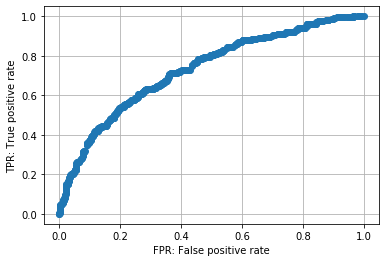

In [28]:
# データ再取得
df = pd.read_csv('../home-credit-default-risk/application_train.csv')

# 文字列のカテゴリカル変数抽出
objct_cols = df.select_dtypes(include=object)
# display(objct_cols)
objct_cols_list = df.select_dtypes(include=object).columns
# print(objct_cols_list)

# 文字列の列の欠損値を変換
df[objct_cols_list] = df[objct_cols_list].fillna('Missing_Data') 
# print(df[objct_cols_list].isnull().sum())

# ターゲットエンコーディング
for col in objct_cols_list:
    label_mean = df.groupby(col).TARGET.mean() # groupby()でラベル分した後にラベル毎の'label'の列の平均を取得
    df[col] = df[col].map(label_mean).copy() # df[C]に値を代入
# df[objct_cols_list]

# 欠損値処理
df = df.dropna() # 欠損値がある行を削除
# df = df.fillna(df.mean()) # 欠損値を平均に置き換え
# df = df.fillna(df.median()) # 欠損値を中央値に置き換え

# print(df.isnull().sum())
# print(df.shape)

# データとターゲットに分割
target = df.pop('TARGET')

# 短変量統計
select = SelectPercentile(percentile=3) # select 1% features
select.fit(df, target)
mask = select.get_support()
df_selected = select.transform(df) # type:dataFrame->ndarray

print(df.columns[np.where(mask==True)])

# ndarrayに変換
target = target.values

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_selected, target, test_size=0.25, random_state=42)
# X_train.shape


# モデル構築
model_2 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)


model_2.fit(X_train, np.ravel(y_train))
y_train_pred_2 = model_2.predict(X_train)
y_test_pred_2 = model_2.predict(X_test)

X_train = np.concatenate([X_train, y_train_pred_2.reshape(-1, 1)], 1)
X_test = np.concatenate([X_test, y_test_pred_2.reshape(-1, 1)], 1)

model_3 = RandomForestClassifier(n_estimators = 10, max_depth= 5, random_state= 42)
model_3.fit(X_train, np.ravel(y_train))

y_pred_3 = model_3.predict(X_test)
y_pred_proba_3 = model_3.predict_proba(X_test)

print('Accuracy\n', model_3.score(X_test, y_test))
print('\nROC AUC SCORE\n', roc_auc_score(y_test, y_pred_proba_3[:,1]))
print('\nConfusion Matrix\n',confusion_matrix(y_test, y_pred_3))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_3[:,1])

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()